<a href="https://colab.research.google.com/github/18521509/CS115/blob/main/CS115_MINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tính Mutual Information giữa: 
- Input và các layer trong mạng nơ-ron (MI X-Layer)
- Label và các layer trong mạng nơ-ron (MI Y-Layer)

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import holoviews as hv
import numpy as np

#Tạo MINE

In [ ]:

class Net(nn.Module):
    def __init__(self,dimX = 1, dimY = 1, H = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(dimX, H)
        self.fc2 = nn.Linear(dimY, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2


def MINE(x,y,n_epoch = 500, H = 10):
    dimX = x.shape[1]
    dimY = y.shape[1]
    model = Net(dimX,dimY,H)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    plot_loss = []
    for epoch in range(n_epoch):
        x_sample= x.copy()
        y_sample= y.copy()
        y_shuffle=np.random.permutation(y_sample)
        
        x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor), requires_grad = True)
        y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor), requires_grad = True)    
        
        pred_xy = model(x_sample, y_sample)
        pred_x_y = model(x_sample, y_shuffle)

        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        loss = - ret  # maximize
        plot_loss.append(loss.data.numpy())
        model.zero_grad()
        loss.backward()
        optimizer.step()
    return -plot_loss[-1]

# x=gen_x()
# y=gen_y(x)
# MINE(x,y)

#Đọc dữ liệu đã train và tính MI bằng MINE


In [ ]:
#Đọc dữ liệu:
import pickle
ws_path = '/content/drive/MyDrive/CS115/data/ws.dat'
y_path = '/content/drive/MyDrive/CS115/data/Y_data.dat'
x_path = '/content/drive/MyDrive/CS115/data/X_data.dat'

with open(ws_path,'rb') as f:
    ws = pickle.load(f)
    f.close()

with open(y_path,'rb') as f:
    y_data = pickle.load(f)
    f.close()

with open(x_path,'rb') as f:
    x_data = pickle.load(f)
    f.close()
y_data = y_data.reshape(-1,1)

In [ ]:
#Tính MI và lưu.
from tqdm.auto import tqdm
import pandas as pd
n_epochs = len(ws)
n_layers = len(ws[0])
# n_epochs = 5
# n_layers = 2

mi_epoch = 1000
H = 30

res = dict()
for i in range(n_layers):
    res[f'MINE X_Layer {i+1}'] = [] 

for i in range(n_layers):
    res[f'MINE Y_Layer {i+1}'] = [] 

for epoch in tqdm(range(n_epochs)):
    for layer in range(n_layers):
        mi_x =  MINE(ws[epoch][layer],x_data,n_epoch= mi_epoch, H = H)
        mi_y =  MINE(ws[epoch][layer],y_data,n_epoch= mi_epoch, H = H)

        res[f'MINE X_Layer {layer+1}'].append(mi_x)
        res[f'MINE Y_Layer {layer+1}'].append(mi_y)

path = '/content/drive/MyDrive/CS115/res/MINE H30 1000eps.csv'
df = pd.DataFrame(res)
df.to_csv(path,index = False)

In [ ]:
def read_mi(path):
    f = open(path,'r')
    mi = list(map(float,f.read().split()))
    return mi

In [ ]:
x_path = '/content/x_layers.txt' 
y_path = '/content/y_layers.txt'

kraskov_x = [[] for _ in range(6)]
kraskov_y = [[] for _ in range(6)]

mi_x = read_mi(x_path)
mi_y = read_mi(y_path)

for i in range(6):
   for j in range(i,600,6):
       kraskov_x[i].append(mi_x[j])
       kraskov_y[i].append(mi_y[j])


#Plot

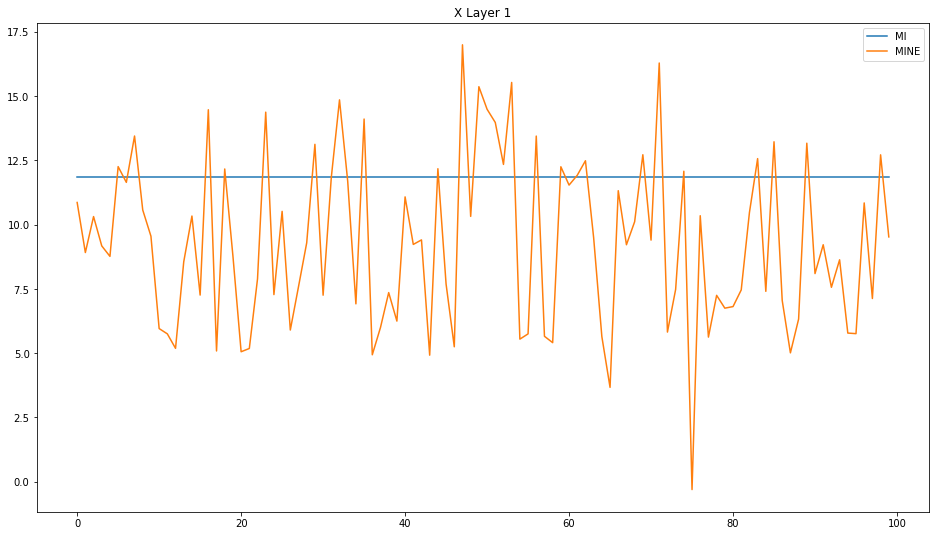

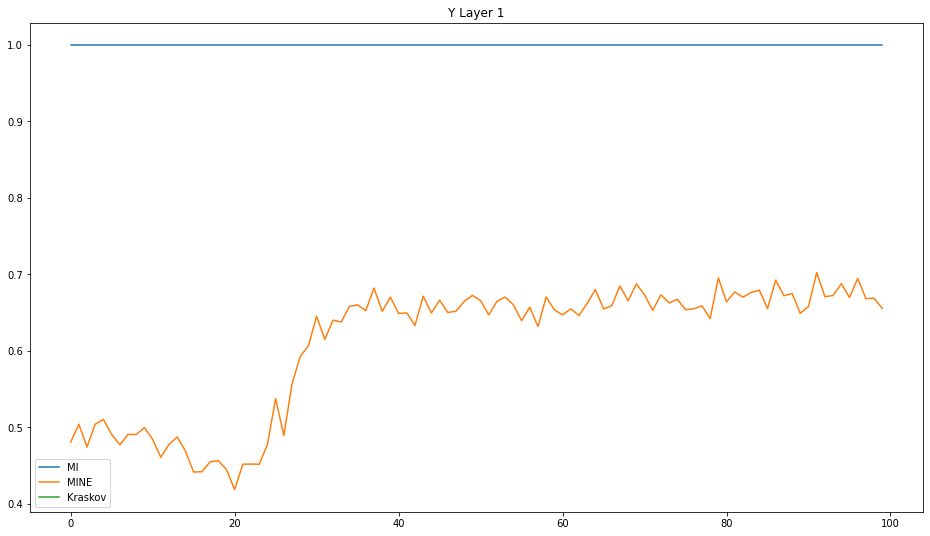

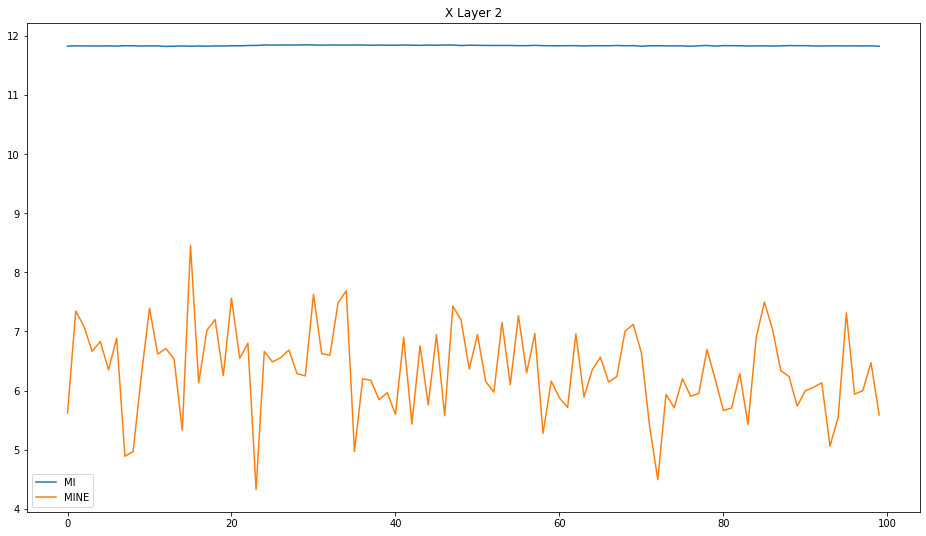

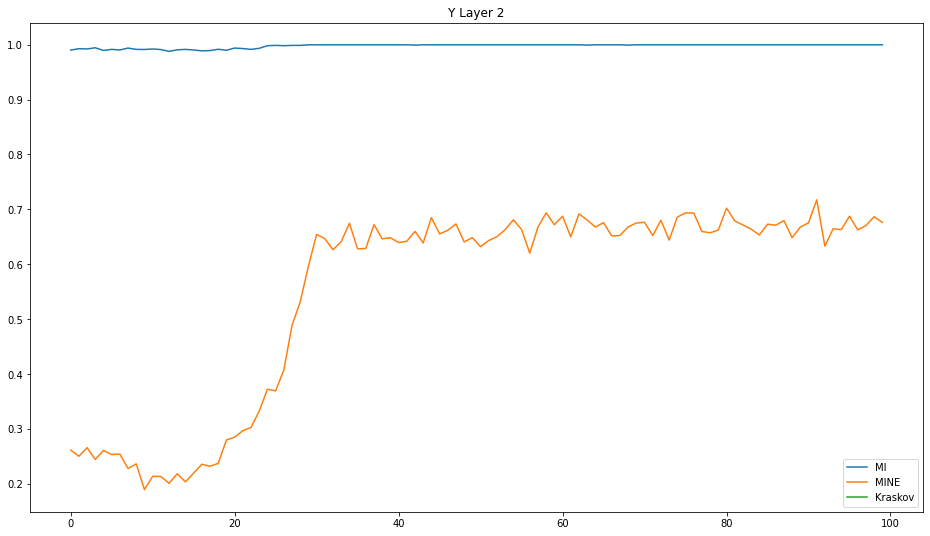

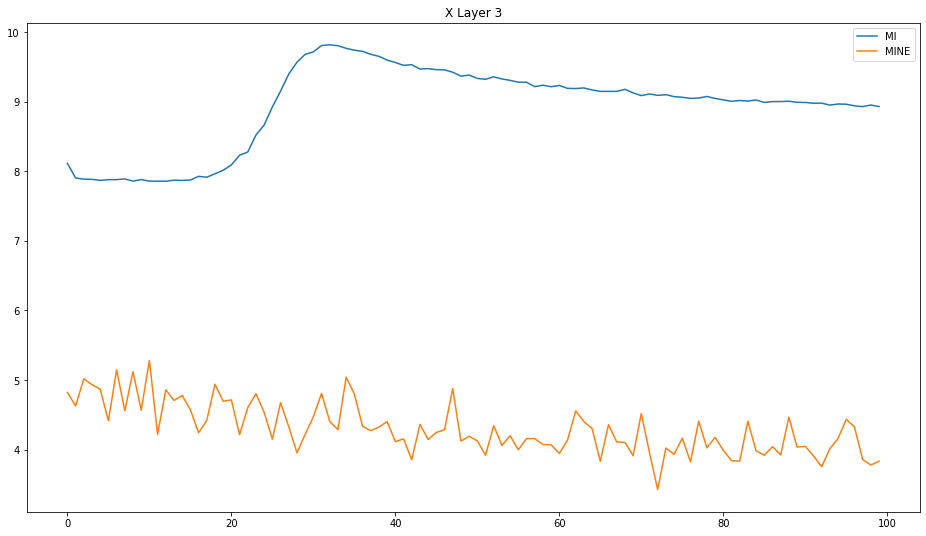

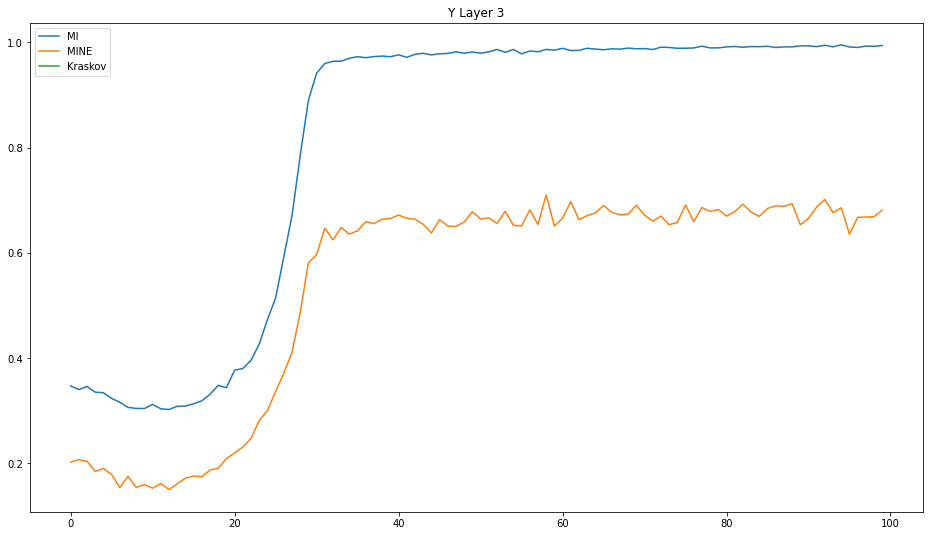

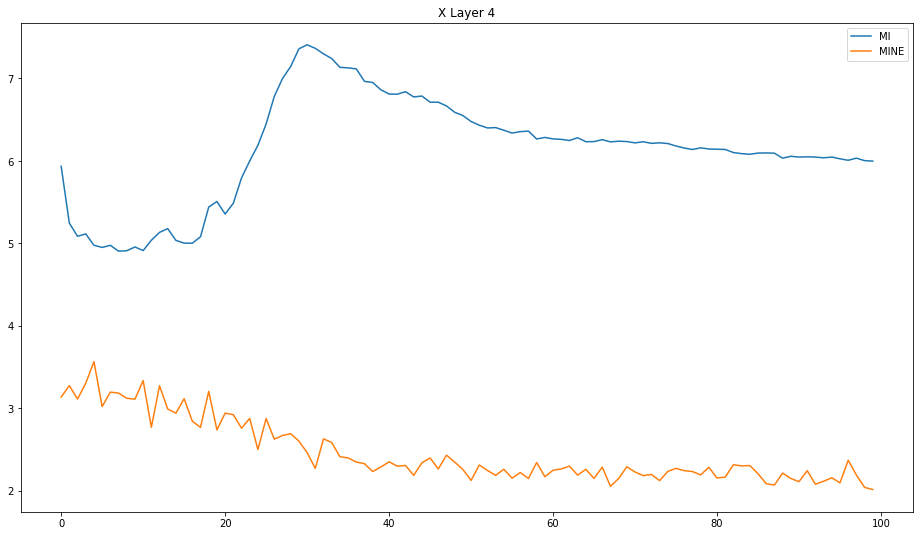

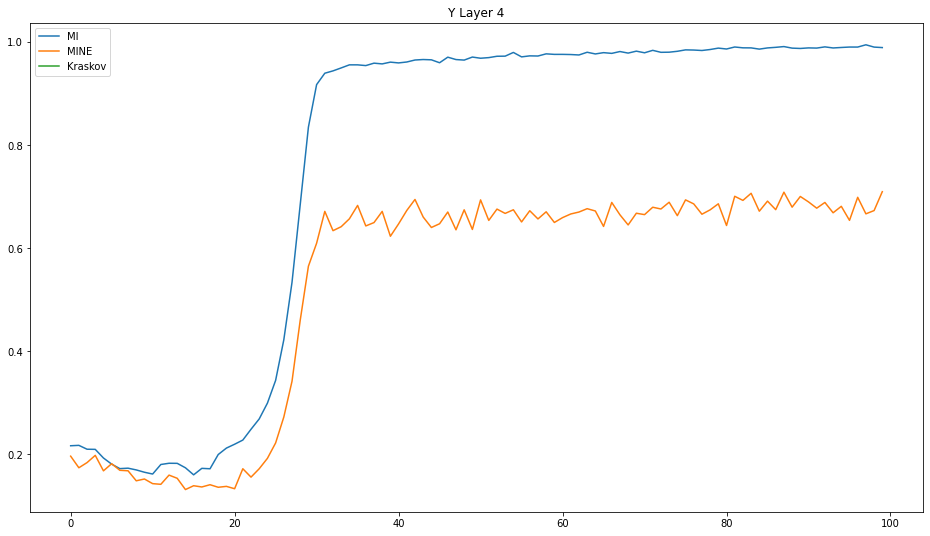

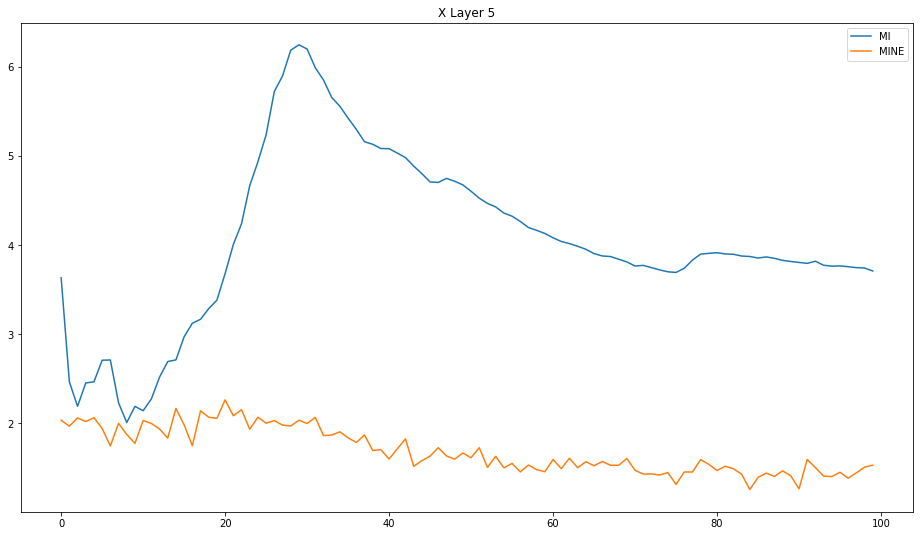

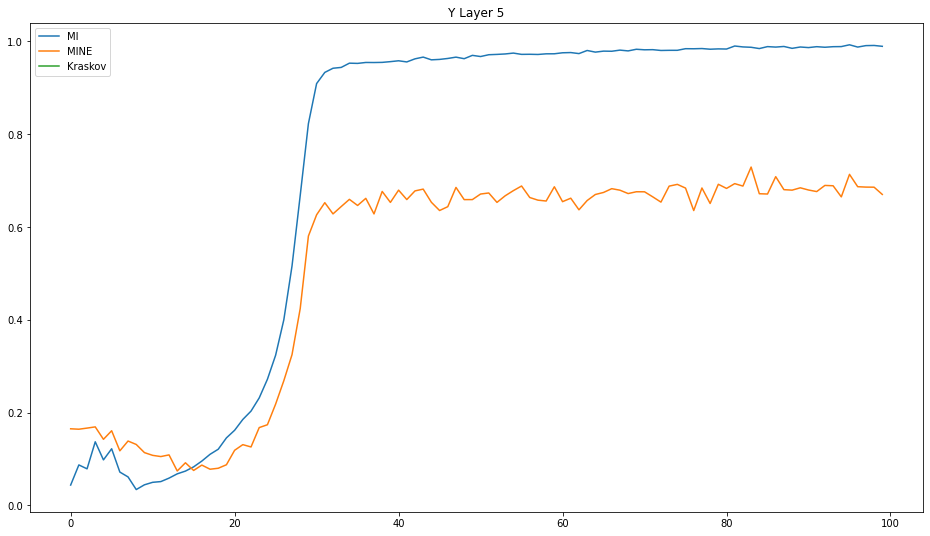

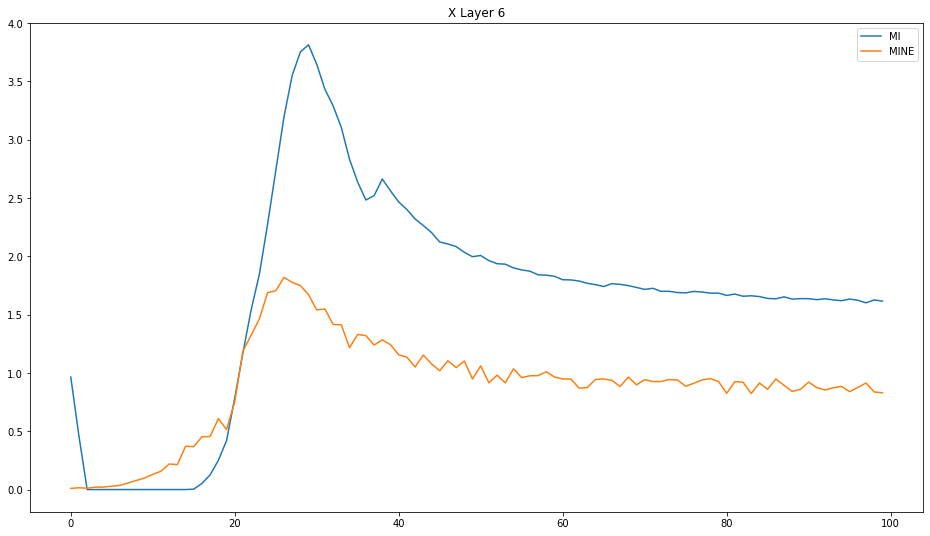

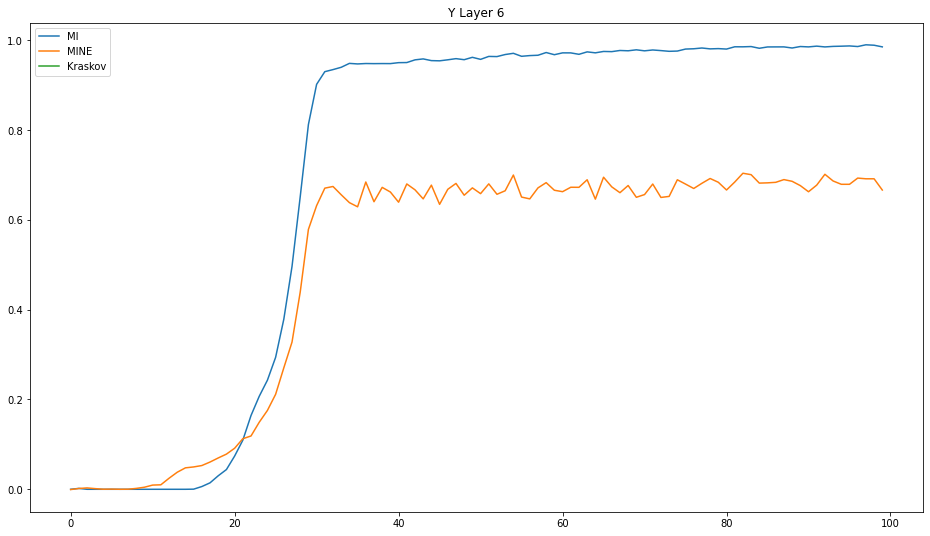

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import os

plot = '/content/drive/MyDrive/CS115/plot/H30 1000eps'
path_MINE = '/content/drive/MyDrive/CS115/res/MINE H30 1000eps.csv'
path_MI =   '/content/drive/MyDrive/CS115/res/MI.csv'

MINE = pd.read_csv(path_MINE)
MI = pd.read_csv(path_MI)

MINE_X = []
MINE_Y = []
X = [f'MINE X_Layer {i+1}' for i in range(6)]
Y = [f'MINE Y_Layer {i+1}' for i in range(6)]
for i in range(6):
    MINE_X.append(list(MINE[X[i]]))
    MINE_Y.append(list(MINE[Y[i]]))

MI_X = []
MI_Y = []
X = [f'X_Layer {i+1}' for i in range(6)]
Y = [f'Y_Layer {i+1}' for i in range(6)]

for i in range(6):
    MI_X.append(list(MI[X[i]]))
    MI_Y.append(list(MI[Y[i]]))

for i in range(6):
    plt.figure(figsize = (16,9))
    plt.title(f'X Layer {i+1}')
    plt.plot(MI_X[i],label = 'MI')
    plt.plot(MINE_X[i],label = 'MINE')
    # plt.plot(kraskov_x[i],label='Kraskov')
    plt.legend()
    plt.savefig(os.path.join(plot,f'X Layer {i+1}.png'))

    plt.figure(figsize = (16,9))
    plt.title(f'Y Layer {i+1}')
    plt.plot(MI_Y[i],label = 'MI')
    plt.plot(MINE_Y[i],label = 'MINE')
    plt.plot(kraskov_y[i],label='Kraskov')
    plt.legend()
    plt.savefig(os.path.join(plot,f'Y Layer {i+1}.png'))

- 